<a href="https://colab.research.google.com/github/nicolascavalli/Forma-o-em-Dados/blob/main/Predi%C3%A7%C3%A3o_Churn_Streaming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Entendimento do Negócio

A diretoria está preocupada com o alto índice de usuários cancelando as suas assinaturas. Eles acreditam que é possível prever se um usuário tem mais chance de deixar a plataforma antes que isso aconteça, e com base nessa informação tomar ações para reduzir o churn. O objetivo é criar um modelo de classificação capaz de prever se um usuário tem mais chance de cancelar a sua assinatura na plataforma ou não. Para isso, a empresa forneceu uma base de dados em csv contendo dados sobre as contas dos clientes.

##Análise exploratória dos dados (Data Understanding)

In [83]:
#Carregando a base de dados no colab
from google.colab import files
uploaded = files.upload()

Saving streaming_data.csv to streaming_data (1).csv


In [84]:
#Importando as bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, scale

In [85]:
#Lendo o arquivo csv
df = pd.read_csv('streaming_data.csv')
df.head()

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
0,49.0,Male,4700.0,3.0,Basic,NaN,3,NaN,0.0,a271aa56-bcfc-4f0a-91f7-b773de6b86a4
1,69.0,Female,6107.0,2.0,Standard,NaN,1,2.14,0.0,fe14b048-770b-4619-8ec6-485b0969ae31
2,44.0,Male,6374.0,3.0,Premium,1.0,1,1.91,1.0,0283dffd-6684-4a05-9c6f-c02098a6849d
3,26.0,Male,NaN,5.0,Basic,NaN,2,NaN,NaN,c316f2f5-3403-4a0a-82c2-c98e4b3379d2
4,18.0,NaN,1948.0,3.0,Basic,NaN,3,3.88,0.0,14879bcb-1977-4ad8-a7f9-6aa9bf7b872f


In [86]:
#Verificando o tamanho do dataset
df.shape

(77884, 10)

In [87]:
#Verificando os tipos de dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77884 entries, 0 to 77883
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     66607 non-null  float64
 1   Gender                  63368 non-null  object 
 2   Time_on_platform        56464 non-null  float64
 3   Devices_connected       52696 non-null  float64
 4   Subscription_type       52663 non-null  object 
 5   Num_streaming_services  9572 non-null   float64
 6   Num_active_profiles     77884 non-null  int64  
 7   Avg_rating              60614 non-null  float64
 8   Churned                 61148 non-null  float64
 9   User_id                 77884 non-null  object 
dtypes: float64(6), int64(1), object(3)
memory usage: 5.9+ MB


Podemos notar pelo `df.info` temos dados nulos nas maiorias das colunas da base. Há também uma necessidade de modificar os tipos de dados de algumas variáveis de float para int.


In [88]:
#Verificando a quantidade de dados nulos em cada feature
df.isnull().sum()

Age                       11277
Gender                    14516
Time_on_platform          21420
Devices_connected         25188
Subscription_type         25221
Num_streaming_services    68312
Num_active_profiles           0
Avg_rating                17270
Churned                   16736
User_id                       0
dtype: int64

In [89]:
#Verificando se temos duplicatas
df[df.duplicated(keep=False)]

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
3,26.0,Male,NaN,5.0,Basic,NaN,2,NaN,NaN,c316f2f5-3403-4a0a-82c2-c98e4b3379d2
7,56.0,Male,462.0,1.0,NaN,3.0,4,3.74,1.0,9ea4f106-8533-4ee2-b7b5-31691f82b72e
8,25.0,Female,3783.0,3.0,NaN,1.0,2,2.92,0.0,2c6f08fb-82be-4e3d-b40d-6aea787c3bd5
20,20.0,Male,2542.0,5.0,Basic,NaN,1,NaN,1.0,b4da071a-c8b4-44dd-84fb-7de32abf766f
21,18.0,Female,4796.0,2.0,NaN,NaN,1,NaN,1.0,2bd75dbe-2fd9-48dd-9c61-864fa08b6afe
...,...,...,...,...,...,...,...,...,...,...
77879,45.0,Male,NaN,NaN,Basic,NaN,5,2.20,0.0,6b51fe0d-d4a1-41ed-a55c-d05f5c961e3c
77880,47.0,Female,6176.0,NaN,Premium,NaN,2,4.54,0.0,59d70167-6be0-474c-b71e-14153205b44f
77881,64.0,Female,NaN,5.0,Premium,NaN,1,4.34,1.0,a7d5ed26-78a4-4e70-bd04-0fec883e56aa
77882,58.0,Male,1314.0,5.0,Standard,NaN,4,NaN,0.0,472e9e70-87ca-4c5e-bfee-fa9f42b54f51


In [90]:
#Identificar quantos valores duplicados há em cada duplicata
(
 df.groupby(df.columns.to_list(), dropna=False)
 .size()
 .to_frame('n_duplicates')
 .query('n_duplicates>1').sort_values('n_duplicates', ascending=False)
)

n_duplicates
Age  Gender Time_on_platform Devices_connected Subscription_type Num_streaming_services Num_active_profiles Avg_rating Churned User_id                                           
18.0 Female 174.0            4.0               Basic             NaN                    1                   4.91       0.0     5caf911f-7e3e-41fe-81e8-b92c1486d511             2
58.0 Female 7680.0           2.0               NaN               NaN                    5                   NaN        0.0     43891e92-ae54-45ac-b180-52d9563b29fc             2
            NaN              NaN               Premium           NaN                    2                   2.82       0.0     3be60fd4-f7a7-4f6a-ab97-fd53f8c7e565             2
                                               Standard          NaN                    1                   1.35       NaN     dd987b62-33cc-44bb-8b2c-102dee37def3             2
                                                                                        2                   NaN        NaN     1f7035d1-82b2-4b9d-ab05-259b04d0b264             2
...                                                                                                                                                                           ...
38.0 Female 3559.0           NaN               NaN               NaN                    3                   NaN        0.0     3c707edb-ee15-4f15-98bd-59861adef4b8             2
            3613.0           1.0               Standard          NaN                    2                   2.95       NaN     498f2952-4271-4f04-aa14-7f24a3983131             2
            3791.0           NaN               Premium           NaN                    5                   1.42       0.0     4857782d-bcc2-4f9c-9980-1304fa5f7ab5             2
            3929.0           5.0               Standard          NaN                    1                   NaN        0.0     b6b87b9f-c5e7-495d-a28e-03451d8486a8             2
NaN  NaN    NaN              NaN               NaN               NaN                    4                   2.28       0.0     6e9cc749-f1de-493c-8ce0-ea91c56d373c             2

[12403 rows x 1 columns]

Temos mais de 12000 linhas com valores duplicados. Essas linhas serão excluídas da nossa análise

In [91]:
#Removendo os itens duplicados
df.drop_duplicates(inplace=True)

In [92]:
#Verificando a nova base de dados
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65481 entries, 0 to 65480
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     55973 non-null  float64
 1   Gender                  53317 non-null  object 
 2   Time_on_platform        47516 non-null  float64
 3   Devices_connected       44296 non-null  float64
 4   Subscription_type       44301 non-null  object 
 5   Num_streaming_services  8089 non-null   float64
 6   Num_active_profiles     65481 non-null  int64  
 7   Avg_rating              50980 non-null  float64
 8   Churned                 51376 non-null  float64
 9   User_id                 65481 non-null  object 
dtypes: float64(6), int64(1), object(3)
memory usage: 5.5+ MB


<Axes: xlabel='Age', ylabel='Count'>

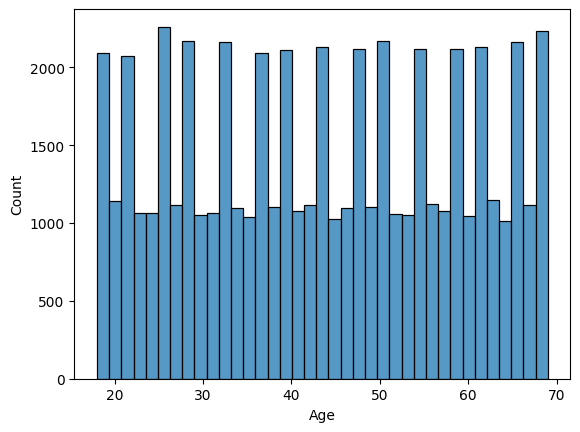

In [93]:
#Análises de Distribuição
sns.histplot(data=df, x='Age')

<Axes: xlabel='Gender', ylabel='Count'>

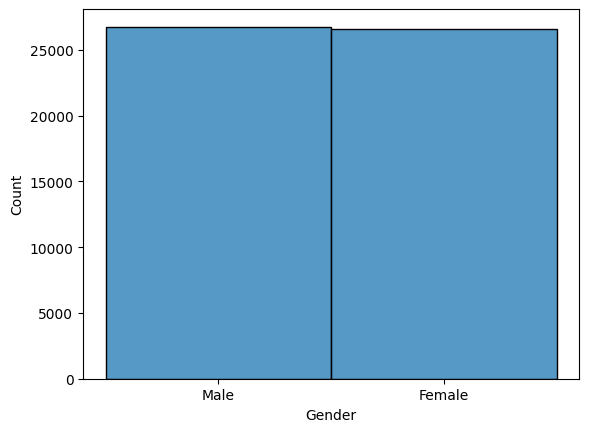

In [94]:
#Análises de Distribuição
sns.histplot(data=df, x='Gender')

<Axes: xlabel='Churned', ylabel='Count'>

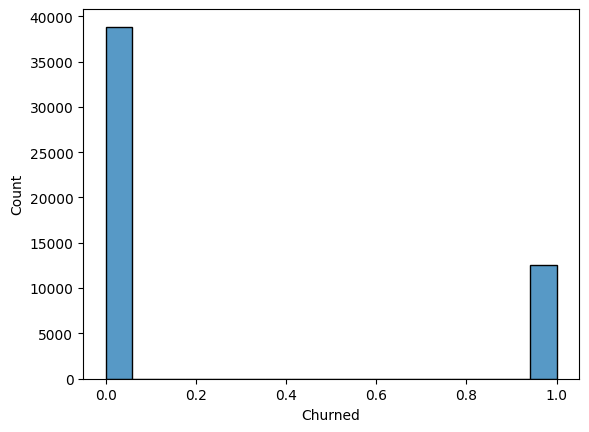

In [95]:
#Análises de Distribuição
sns.histplot(data=df, x='Churned')

Podemos notar que temos uma base desbalanceada em relação a nossa variável alvo 'Churned'.

<Axes: xlabel='Subscription_type', ylabel='Count'>

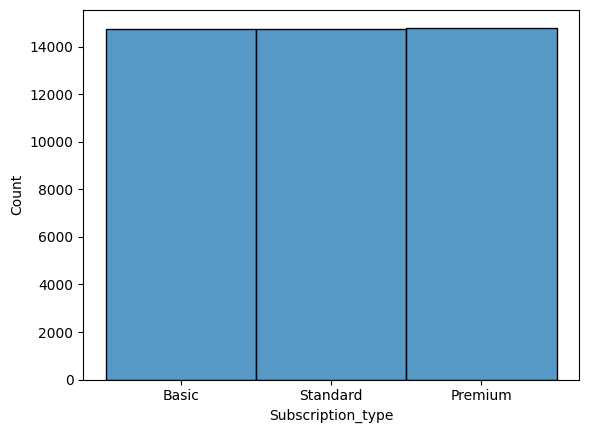

In [96]:
#Análises de Distribuição
sns.histplot(data=df, x='Subscription_type')

In [97]:
df.describe()

,Age,Time_on_platform,Devices_connected,Num_streaming_services,Num_active_profiles,Avg_rating,Churned
count,55973.000000,47516.000000,44296.000000,8089.000000,65481.000000,50980.000000,51376.000000
mean,43.538831,4385.022456,2.998623,2.500680,3.001069,3.003855,0.243888
std,15.042047,2528.167615,1.414572,1.122132,1.412560,1.154427,0.429430
min,18.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,30.000000,2194.000000,2.000000,1.000000,2.000000,2.000000,0.000000
50%,44.000000,4387.000000,3.000000,2.000000,3.000000,3.010000,0.000000
75%,57.000000,6573.000000,4.000000,4.000000,4.000000,4.000000,0.000000
max,69.000000,8759.000000,5.000000,4.000000,5.000000,5.000000,1.000000


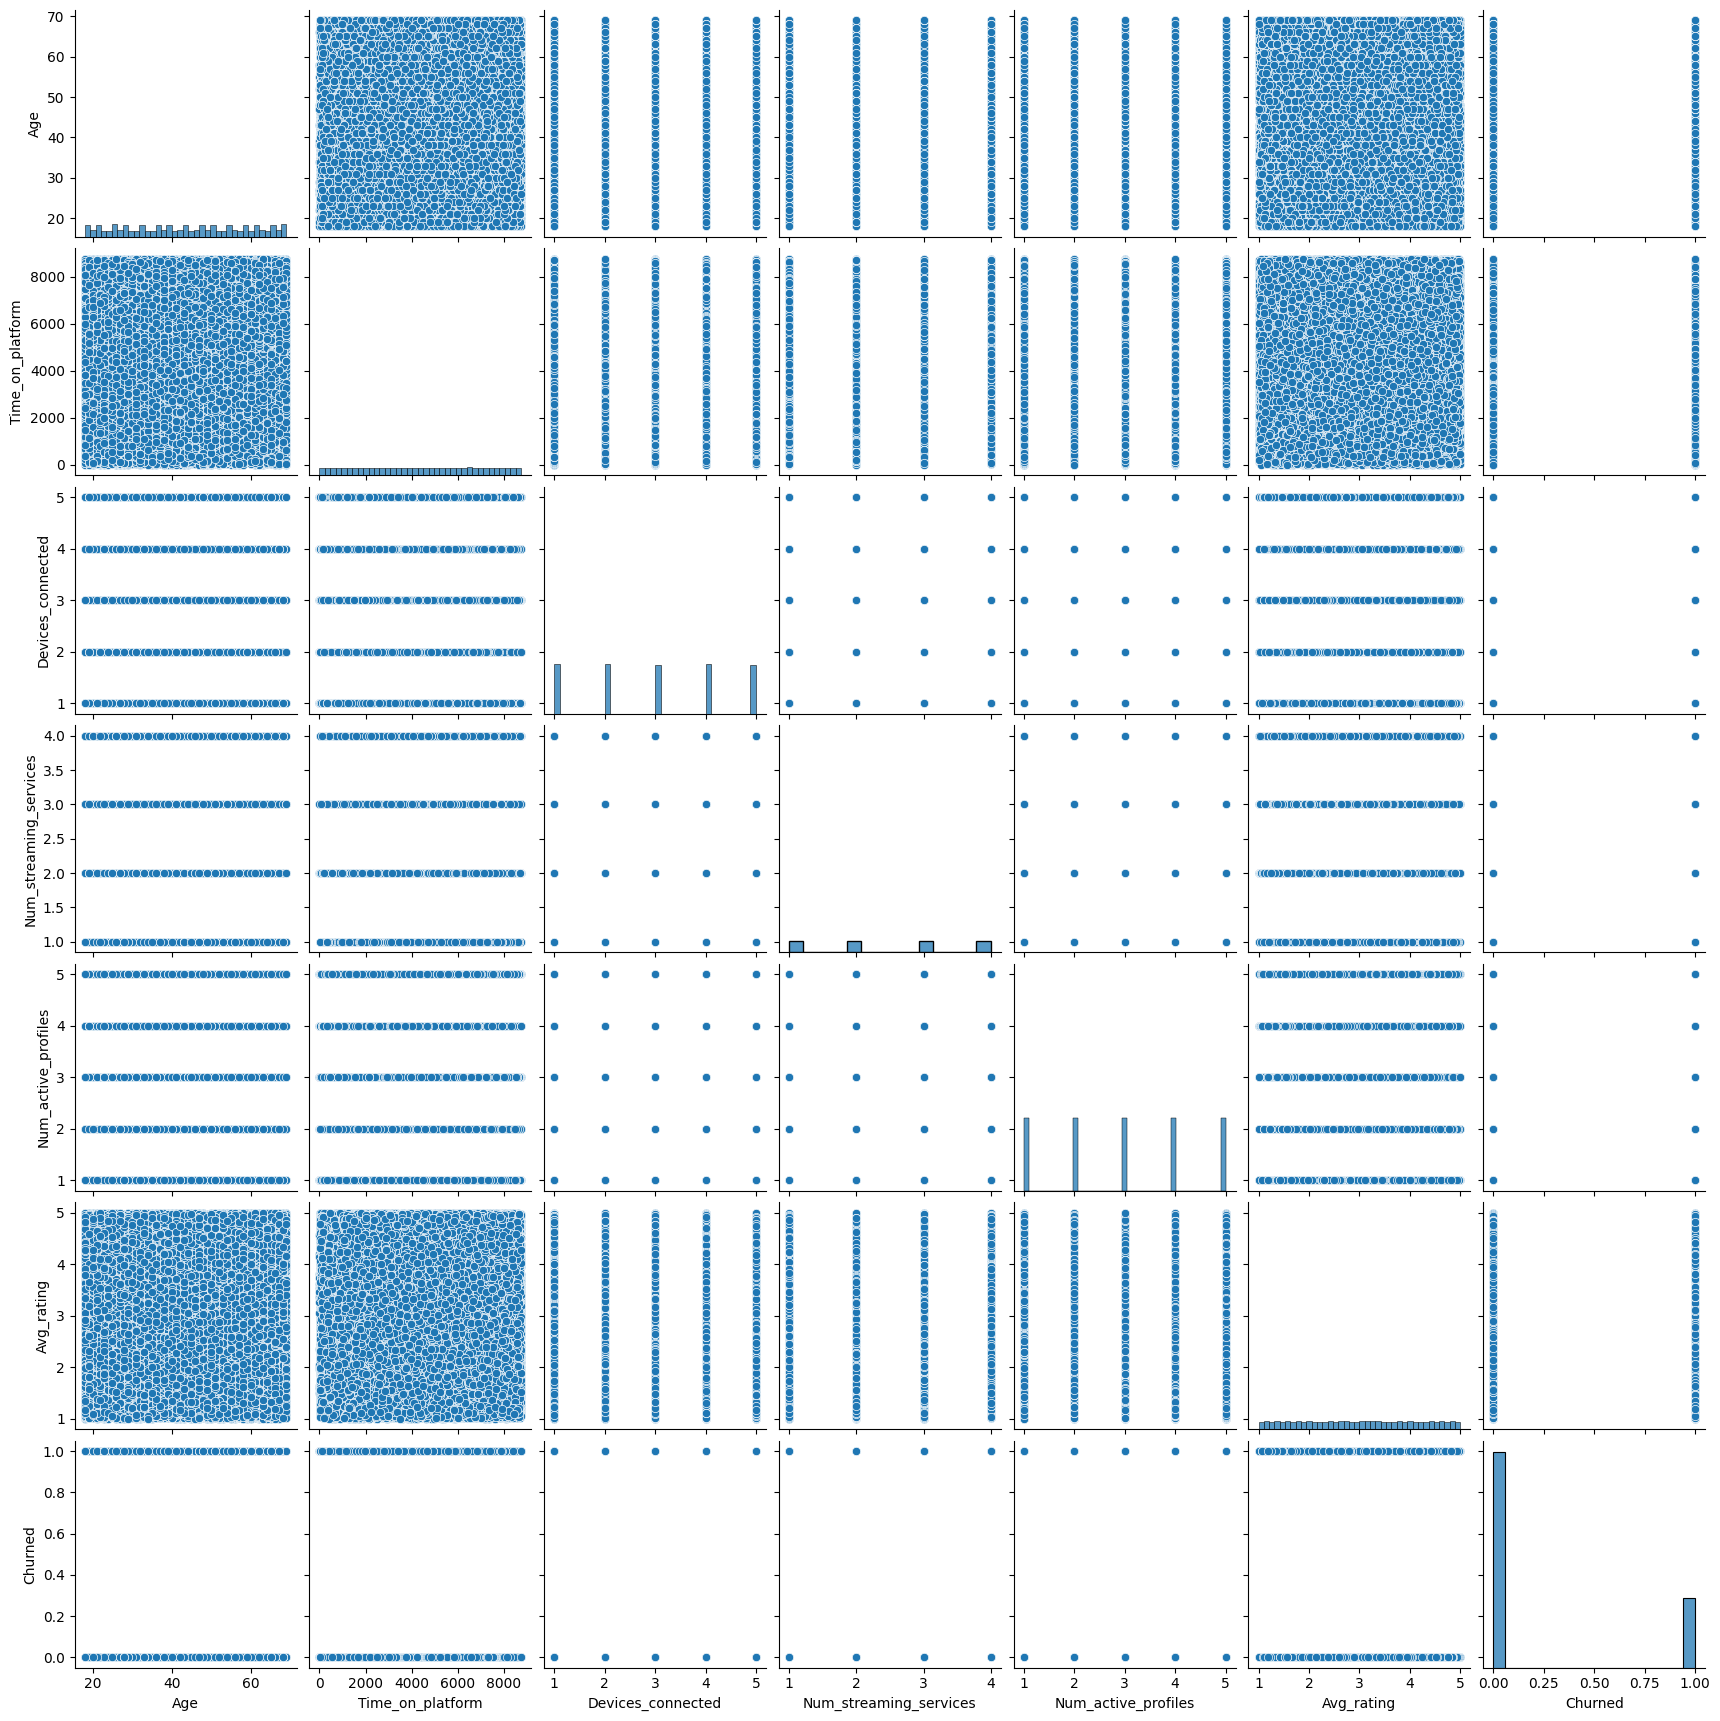

In [98]:
sns.pairplot(df);

<ipython-input-99-6dc1c4c1753e>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


<Axes: >

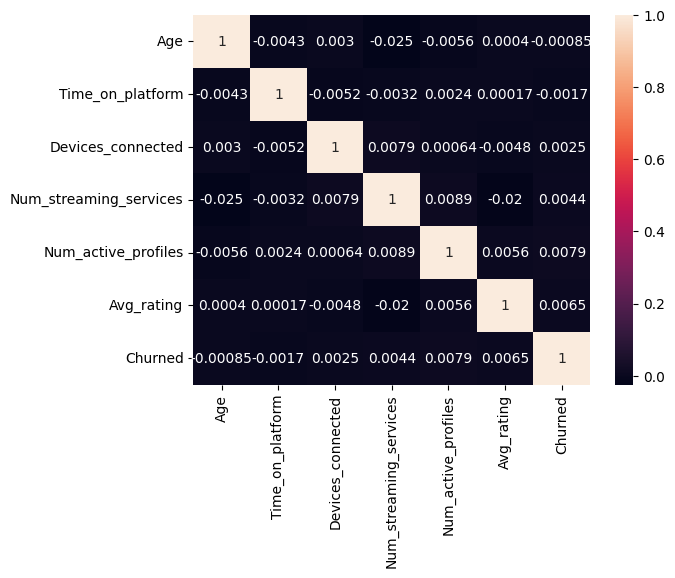

In [99]:
sns.heatmap(df.corr(), annot=True)

Como podemos observar pelos 2 gráficos, não temos uma correlação significante entre as variáveis. Por ora manteremos todas as features no modelo

In [100]:
#Verificando outliers no conjunto de dados


##  Tratamento dos Dados (Data Preparation)

In [101]:
#Substituindo os valores NaN por 0
df[['Time_on_platform', 'Num_streaming_services', 'Churned',  'Avg_rating',  'Devices_connected']] = df[['Time_on_platform', 'Num_streaming_services', 'Churned',  'Avg_rating',  'Devices_connected']].fillna(0)

In [102]:
df.isna().sum()

Age                        9508
Gender                    12164
Time_on_platform              0
Devices_connected             0
Subscription_type         21180
Num_streaming_services        0
Num_active_profiles           0
Avg_rating                    0
Churned                       0
User_id                       0
dtype: int64

Como visto acima, os valores nulos das colunas tratadas foram eliminados

In [103]:
#Dropando os linhas nulas das colunas restantes com valores nulos
df.dropna(inplace=True)
df.isna().sum()

Age                       0
Gender                    0
Time_on_platform          0
Devices_connected         0
Subscription_type         0
Num_streaming_services    0
Num_active_profiles       0
Avg_rating                0
Churned                   0
User_id                   0
dtype: int64

Agora nenhuma coluna apresenta valores nulos

In [104]:
df.shape

(30739, 10)

In [105]:
#Substituindo os valores da variável alvo para valores categóricos
df['Churned'].replace([1, 0], ['Yes', 'No'], inplace=True)
df.head()

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
0,49.0,Male,4700.0,3.0,Basic,0.0,3,0.00,No,a271aa56-bcfc-4f0a-91f7-b773de6b86a4
1,69.0,Female,6107.0,2.0,Standard,0.0,1,2.14,No,fe14b048-770b-4619-8ec6-485b0969ae31
2,44.0,Male,6374.0,3.0,Premium,1.0,1,1.91,Yes,0283dffd-6684-4a05-9c6f-c02098a6849d
3,26.0,Male,0.0,5.0,Basic,0.0,2,0.00,No,c316f2f5-3403-4a0a-82c2-c98e4b3379d2
5,54.0,Male,3024.0,2.0,Basic,0.0,1,0.00,No,a1df3a13-9255-4d00-8a9d-20565fefaab9


In [106]:
#Transformando as colunas de float pra int
df[['Age', 'Devices_connected', 'Time_on_platform', 'Num_streaming_services']] = df[['Age', 'Devices_connected', 'Time_on_platform', 'Num_streaming_services']].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30739 entries, 0 to 65479
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     30739 non-null  int64  
 1   Gender                  30739 non-null  object 
 2   Time_on_platform        30739 non-null  int64  
 3   Devices_connected       30739 non-null  int64  
 4   Subscription_type       30739 non-null  object 
 5   Num_streaming_services  30739 non-null  int64  
 6   Num_active_profiles     30739 non-null  int64  
 7   Avg_rating              30739 non-null  float64
 8   Churned                 30739 non-null  object 
 9   User_id                 30739 non-null  object 
dtypes: float64(1), int64(5), object(4)
memory usage: 2.6+ MB


In [107]:
#Dropando a coluna User_id
df.drop(columns='User_id', inplace=True)
df.head()

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned
0,49,Male,4700,3,Basic,0,3,0.00,No
1,69,Female,6107,2,Standard,0,1,2.14,No
2,44,Male,6374,3,Premium,1,1,1.91,Yes
3,26,Male,0,5,Basic,0,2,0.00,No
5,54,Male,3024,2,Basic,0,1,0.00,No


Dropamos a coluna user_id pq não usaremos modelos de NLP para a abordagem do problema

In [108]:
#Aplicando o LabelEncoder para os atributos categóricos
le = LabelEncoder()
df[['Gender', 'Subscription_type']] = df[['Gender', 'Subscription_type']].apply(le.fit_transform)
df.head()

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned
0,49,1,4700,3,0,0,3,0.00,No
1,69,0,6107,2,2,0,1,2.14,No
2,44,1,6374,3,1,1,1,1.91,Yes
3,26,1,0,5,0,0,2,0.00,No
5,54,1,3024,2,0,0,1,0.00,No


## Modelagem dos Dados - Regressão Logística

In [109]:
#Separando o dataset em atributos e variável alvo
X = df.drop(columns='Churned')
y = df[['Churned']]

In [110]:
#Normalizando o dataset de atributos
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X = pd.DataFrame(mms.fit_transform(X), index=X.index, columns=X.columns)
X.head()

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating
0,0.607843,1.0,0.536591,0.6,0.0,0.00,0.50,0.000
1,1.000000,0.0,0.697226,0.4,1.0,0.00,0.00,0.428
2,0.509804,1.0,0.727709,0.6,0.5,0.25,0.00,0.382
3,0.156863,1.0,0.000000,1.0,0.0,0.00,0.25,0.000
5,0.705882,1.0,0.345245,0.4,0.0,0.00,0.00,0.000


In [111]:
#Separando o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [112]:
#Treinando o modelo de Regressão Logística
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [113]:
#Predizendo o resultado para a base de teste
lr_pred = lr.predict(X_test)

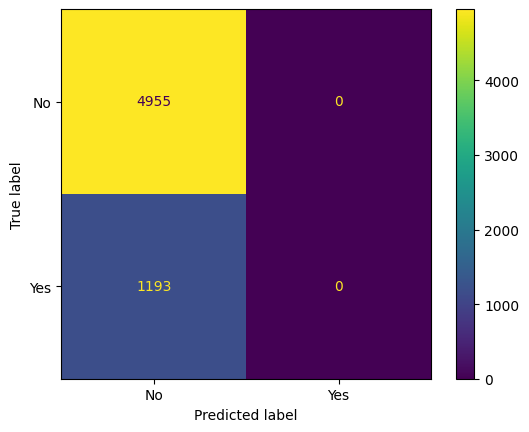

In [114]:
#Conferindo as métricas do modelo
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix
matriz_confusao = confusion_matrix(y_test, lr_pred, labels=lr.classes_)
ConfusionMatrixDisplay(matriz_confusao, display_labels=lr.classes_).plot()

In [115]:
#Plotando as métricas para o modelo em questão
print(f'Train Accuracy: {accuracy_score(y_train, lr.predict(X_train))}')
print(f'Test Accuracy: {accuracy_score(y_test, lr_pred):.4f}')

print(f'Train Balanced Accuracy: {balanced_accuracy_score(y_train, lr.predict(X_train))}')
print(f'Test Balanced Accuracy: {balanced_accuracy_score(y_test, lr_pred):.4f}')

print(f'Train ROC_AUC: {roc_auc_score(y_train, lr.predict_proba(X_train)[:,1])}')
print(f'Test ROC_AUC: {roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]):.4f}')

Train Accuracy: 0.8059452645276727
Test Accuracy: 0.8060
Train Balanced Accuracy: 0.5
Test Balanced Accuracy: 0.5000
Train ROC_AUC: 0.5176810423519778
Test ROC_AUC: 0.4768


## Modelagem dos Dados - Random Forest

In [116]:
#Treinando o modelo de RandomForest
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

<ipython-input-116-7fe2f6ceaf66>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


RandomForestClassifier()

In [117]:
#Predizendo os valores para a base de teste
rfc_pred = rfc.predict(X_test)

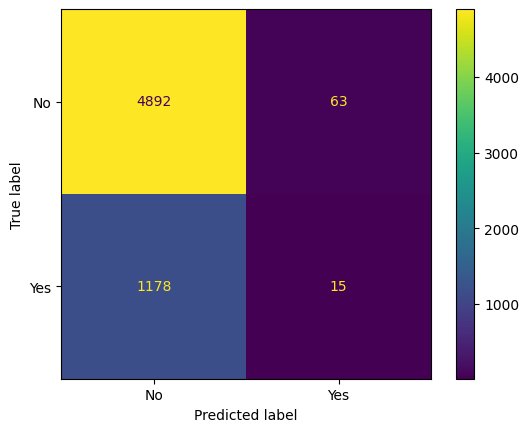

In [118]:
#Plotando a matriz de confusão
matriz_confusao = confusion_matrix(y_test, rfc_pred, labels=rfc.classes_)
ConfusionMatrixDisplay(matriz_confusao, display_labels=rfc.classes_).plot()

In [119]:
#Plotando as métricas para o modelo em questão
print(f'Train Accuracy: {accuracy_score(y_train, rfc.predict(X_train))}')
print(f'Test Accuracy: {accuracy_score(y_test, rfc_pred):.4f}')

print(f'Train Balanced Accuracy: {balanced_accuracy_score(y_train, rfc.predict(X_train))}')
print(f'Test Balanced Accuracy: {balanced_accuracy_score(y_test, rfc_pred):.4f}')

print(f'Train ROC_AUC: {roc_auc_score(y_train, rfc.predict_proba(X_train)[:,1])}')
print(f'Test ROC_AUC: {roc_auc_score(y_test, rfc.predict_proba(X_test)[:,1]):.4f}')

Train Accuracy: 0.9984953844902607
Test Accuracy: 0.7981
Train Balanced Accuracy: 0.9966005161041034
Test Balanced Accuracy: 0.4999
Train ROC_AUC: 0.9999782186372591
Test ROC_AUC: 0.4963


Analisando a acurácia da base de treino, nota-se que há um problema de sobreajuste (overfitting), e por isso aplicaremos o método de Tunning para otimizarmos os hiperparâmetros do modelo e solucionarmos o caso de overfitting.

## Modelagem dos Dados - Tunning

In [120]:
#Definindo o grid de parâmetros e aplicando o GridSearch para o modelo RandomForest
parametros = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'n_estimators':[100, 300, 500]}
gscv = GridSearchCV(rfc, param_grid=parametros, scoring='accuracy', n_jobs=-1, cv=5)
gscv.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [100, 300, 500]},
             scoring='accuracy')

In [121]:
#Verificando o ranking de resultados
resultado = pd.DataFrame(gscv.cv_results_)
resultado.sort_values(by='rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.930721,0.182450,0.076877,0.025957,1,100,"{'max_depth': 1, 'n_estimators': 100}",0.805855,0.806019,0.806019,0.806019,0.805815,0.805945,0.000091,1
27,2.134970,0.138522,0.109178,0.008171,10,100,"{'max_depth': 10, 'n_estimators': 100}",0.805855,0.806019,0.806019,0.806019,0.805815,0.805945,0.000091,1
26,10.570357,0.241323,0.454503,0.101592,9,500,"{'max_depth': 9, 'n_estimators': 500}",0.805855,0.806019,0.806019,0.806019,0.805815,0.805945,0.000091,1
25,6.385326,0.553895,0.255424,0.008155,9,300,"{'max_depth': 9, 'n_estimators': 300}",0.805855,0.806019,0.806019,0.806019,0.805815,0.805945,0.000091,1
24,1.907445,0.015656,0.097236,0.001043,9,100,"{'max_depth': 9, 'n_estimators': 100}",0.805855,0.806019,0.806019,0.806019,0.805815,0.805945,0.000091,1
23,9.573721,0.472016,0.377456,0.008197,8,500,"{'max_depth': 8, 'n_estimators': 500}",0.805855,0.806019,0.806019,0.806019,0.805815,0.805945,0.000091,1
22,5.663999,0.549047,0.231996,0.004150,8,300,"{'max_depth': 8, 'n_estimators': 300}",0.805855,0.806019,0.806019,0.806019,0.805815,0.805945,0.000091,1
21,1.959449,0.236010,0.107629,0.033045,8,100,"{'max_depth': 8, 'n_estimators': 100}",0.805855,0.806019,0.806019,0.806019,0.805815,0.805945,0.000091,1
20,8.607722,0.608327,0.339879,0.003354,7,500,"{'max_depth': 7, 'n_estimators': 500}",0.805855,0.806019,0.806019,0.806019,0.805815,0.805945,0.000091,1
19,5.157501,0.371646,0.270750,0.061086,7,300,"{'max_depth': 7, 'n_estimators': 300}",0.805855,0.806019,0.806019,0.806019,0.805815,0.805945,0.000091,1


In [122]:
#Verificando quais são os melhores parâmetros
gscv.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 1,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [123]:
#Treinando novamente o modelo, agora com os melhores hiperparâmetros
rfc_tunned = RandomForestClassifier(bootstrap= True,
 ccp_alpha= 0.0,
 class_weight= None,
 criterion= 'gini',
 max_depth= 1,
 max_features= 'sqrt',
 max_leaf_nodes= None,
 max_samples= None,
 min_impurity_decrease= 0.0,
 min_samples_leaf= 1,
 min_samples_split= 2,
 min_weight_fraction_leaf= 0.0,
 n_estimators= 100,
 n_jobs= None,
 oob_score= False,
 random_state= None,
 verbose= 0,
 warm_start= False)

rfc_tunned.fit(X_train, y_train)

<ipython-input-123-1237d7b4dc7d>:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc_tunned.fit(X_train, y_train)


RandomForestClassifier(max_depth=1)

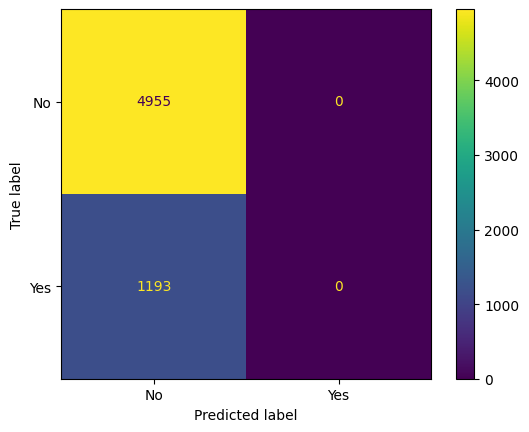

In [124]:
#Plotando a matriz de confusão
rfc_tunned_pred = rfc_tunned.predict(X_test)
matriz_confusao = confusion_matrix(y_test, rfc_tunned_pred, labels=rfc_tunned.classes_)
ConfusionMatrixDisplay(matriz_confusao, display_labels=rfc_tunned.classes_).plot()

In [125]:
#Plotando as métricas do modelo
print(f'Train Accuracy: {accuracy_score(y_train, rfc_tunned.predict(X_train))}')
print(f'Test Accuracy: {accuracy_score(y_test, rfc_tunned_pred):.4f}')

print(f'Train Balanced Accuracy: {balanced_accuracy_score(y_train, rfc_tunned.predict(X_train))}')
print(f'Test Balanced Accuracy: {balanced_accuracy_score(y_test, rfc_tunned_pred):.4f}')

print(f'Train ROC_AUC: {roc_auc_score(y_train, rfc_tunned.predict_proba(X_train)[:,1])}')
print(f'Test ROC_AUC: {roc_auc_score(y_test, rfc_tunned.predict_proba(X_test)[:,1]):.4f}')

Train Accuracy: 0.8059452645276727
Test Accuracy: 0.8060
Train Balanced Accuracy: 0.5
Test Balanced Accuracy: 0.5000
Train ROC_AUC: 0.5261921045562931
Test ROC_AUC: 0.4709


Nota-se que após a aplicação do `GridSearchCV`tivemos uma redução significativa da acurácia de treino, assim resolvemos o problema de Overfitting. Analisando as métricas dos dois modelos, percebemos que eles ficam muito próximos em relação a performance. Assim, para o objetivo de negócio em questão, qualquer um dos dois modelos poderiam ser utilizados. Como oportunidade de melhoria, seria interesante testar mais modelos de classificação como SVM, DecisionTree e LGBMClassifier para avaliarmos e termos maiores dados para escolher o melhor modelo a ser utilizado.